In [1]:
from exp.utils import *
from exp.models import *
from exp.losses import *
from tqdm.notebook import tqdm
from multiprocessing import Pool
from PIL import Image

import torch
import torch.nn as NN
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms

from matplotlib.colors import LinearSegmentedColormap
from captum.attr import visualization as viz
from captum.attr import IntegratedGradients
from captum.attr import GradientShap
from captum.attr import DeepLift
from captum.attr import Occlusion
from captum.attr import NoiseTunnel
from captum.attr import visualization as viz
from captum.attr import Saliency

from ipywidgets import interact

In [2]:
label = "Atelectasis"
model_name = f"DenseNet121_v1_{label}"
s = 224
image_size = (s, s)#(224, 224)
labels = get_labels()
bs = 1
device = get_cpu()

Using the CPU!


In [3]:
train_df, valid_df, test_df = get_dataframes(include_labels=labels, 
                                             small=False)
print(train_df.shape, valid_df.shape, test_df.shape)
train_df = get_binary_df(label, train_df)
valid_df = get_binary_df(label, valid_df)
test_df = get_binary_df(label, test_df)

train_label = train_df[[label]].values
neg_weights, pos_weights = compute_class_freqs(train_label)
neg_weights, pos_weights = torch.Tensor(neg_weights), torch.Tensor(pos_weights)
print(neg_weights, pos_weights)

train_tfs, test_tfs = get_transforms(image_size=image_size)

train_ds = CRX8_Data(train_df, get_image_path(), label, image_size=image_size, transforms=train_tfs)
valid_ds = CRX8_Data(valid_df, get_image_path(), label, image_size=image_size, transforms=test_tfs)
test_ds  = CRX8_Data(test_df , get_image_path(), label, image_size=image_size, transforms=test_tfs)

train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=bs, shuffle=False)
test_dl  = DataLoader(test_ds,  batch_size=bs, shuffle=False)
dataloaders = {
    "train": train_dl,
    "val": valid_dl,
    "test": test_dl
}

criterion = get_weighted_loss_with_logits(pos_weights.to(device), 
                                          neg_weights.to(device))

/home/favi/work/crx8/exp/utils.py:179: UserWarning: Train-Val-Split currently with patient overlap!
  warnings.warn("Train-Val-Split currently with patient overlap!")


(69219, 24) (17305, 24) (25596, 24)
tensor([0.0956]) tensor([0.9044])


In [4]:
def get_pos_batch(idx):
    if idx == 0: idx = 1
    i = 0
    pos_count = 0
    target_pos = idx
    X, y = get_batch(i, test_dl)
    while True:
        if y.sum() > 0: pos_count += 1
        if pos_count == target_pos: break
        i += 1
        X, y = get_batch(i, test_dl)
    return X, y

def get_neg_batch(idx):
    if idx == 0: idx = 1
    i = 0
    neg_count = 0
    target_pos = idx
    X, y = get_batch(i, test_dl)
    while True:
        if y.sum() < 1: neg_count += 1
        if neg_count == target_pos: break
        i += 1
        X, y = get_batch(i, test_dl)
    return X, y

In [10]:
model = load_model(model_name)
model.eval();

torch.Size([1, 3, 224, 224]) torch.Size([1, 1]) tensor([[1.]])


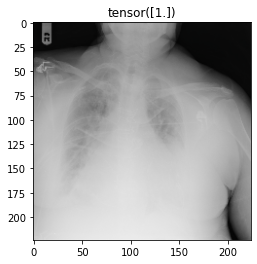

In [13]:
X, y = get_pos_batch(3)
print(X.shape, y.shape, y)
print_image(X[0], y[0])

In [16]:
X, y, model = X.to(device), y.to(device), model.to(device)

In [17]:
pred_prob, _ = torch.topk(NN.Sigmoid()(model(X)), 1)
pred_label = (pred_prob >= 0.5).float()
label_idx = 0
pred_prob, pred_label

(tensor([[0.5296]], grad_fn=<TopkBackward>), tensor([[1.]]))

In [18]:
default_cmap = LinearSegmentedColormap.from_list("orange",[(0, '#000000'),
                                                  (0.25, '#000000'),
                                                  (1, '#fc7b02')], N=256 )


In [19]:
ig = IntegratedGradients(model)
nt = NoiseTunnel(ig)
attrs = []
for _ in tqdm(range(1)):
    model.zero_grad()
    tmp = nt.attribute(X,
                       baselines=X * 0, 
                       nt_type='smoothgrad_sq',
                       nt_samples=4, stdevs=0.2)
    attrs.append(tmp.squeeze())

In [20]:
attr_ig_nt = torch.zeros((len(attrs), *attrs[0].shape))
for i in range(len(attrs)): attr_ig_nt[i] = attrs[i][0]
    
attr_ig_nt = attr_ig_nt.mean(axis=0).cpu().detach().numpy()
array_info(attr_ig_nt);print()
attr_ig_nt = np.transpose(attr_ig_nt, (1, 2, 0))

Shape:	 (3, 224, 224)
Mean:	 8.827722e-07
Std:	 3.1719835e-06
Max:	 0.00016033539
Min:	 6.0749758e-15



In [21]:
transformed_img = X[0].cpu().detach().numpy()
transformed_img = np.einsum("cwh -> whc", transformed_img)
transformed_img = transformed_img * IMAGENET_STD + IMAGENET_MEAN

In [22]:
@interact(percentage=(1, 99))
def drawit(percentage):
    _=viz.visualize_image_attr(attr_ig_nt, 
                             transformed_img, 
                             method="blended_heat_map", 
                             sign="absolute_value", 
                             outlier_perc=percentage, 
                             show_colorbar=True,
                             cmap=default_cmap,
                             title="Overlayed Integrated Gradients \n with SmoothGrad Squared")

interactive(children=(IntSlider(value=50, description='percentage', max=99, min=1), Output()), _dom_classes=('…

In [ ]:
_ = viz.visualize_image_attr(attr_ig_nt, 
                             transformed_img, 
                             method="blended_heat_map", 
                             sign="absolute_value", 
                             outlier_perc=25, 
                             show_colorbar=True,
                             cmap=default_cmap,
                             title="Overlayed Integrated Gradients \n with SmoothGrad Squared")

In [ ]:
dl = DeepLift(model)
attr_dl = dl.attribute(X, target=0, baselines=X * 0)
attr_dl = np.transpose(attr_dl.squeeze(0).cpu().detach().numpy(), (1, 2, 0))

In [ ]:
_ = viz.visualize_image_attr(attr_dl, transformed_img, method="blended_heat_map",sign="all",show_colorbar=True, 
                          title="Overlayed DeepLift")